In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from bs4 import BeautifulSoup
import requests
import scipy.stats as stats
import seaborn as sns
from IPython.display import clear_output
import time

In [12]:
!python -V
print('------')
!pip freeze | findstr pandas
print('------')
!pip freeze | findstr numpy
print('------')
!pip freeze | findstr matplotlib

Python 3.10.6
------
geopandas==0.12.2
pandas==1.5.2
------
numpy==1.23.5
------
matplotlib==3.6.2
matplotlib-inline==0.1.6


In [13]:
#now = datetime.date(2023, 5, 17)
today = datetime.date.today()
seven_days_ago = today- datetime.timedelta(days=7)

def importar_base_bitcoin():        
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision,variacion,df_bitcoin_limpio
    ticker = "BTC-USD" 
    df_bitcoin=yf.Ticker(ticker).history(period="7d",interval="5m") #Opcion 1   
    #df_bitcoin= yf.download(ticker, period='7d',interval="5m") #Opcion 2
    #df_bitcoin= yf.download(ticker, start=seven_days_ago,interval="5m") #Opcion 3
    return df_bitcoin

In [14]:
importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-14 00:00:00+00:00,26788.974609,26807.482422,26785.410156,26785.410156,0,0.0,0.0
2023-05-14 00:05:00+00:00,26787.255859,26787.255859,26765.072266,26768.802734,8161280,0.0,0.0
2023-05-14 00:10:00+00:00,26769.792969,26790.462891,26747.765625,26776.935547,27173888,0.0,0.0
2023-05-14 00:15:00+00:00,26775.757812,26779.638672,26769.892578,26769.892578,4140032,0.0,0.0
2023-05-14 00:20:00+00:00,26755.490234,26770.789062,26755.490234,26763.474609,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-20 05:30:00+00:00,26870.593750,26874.306641,26869.308594,26874.306641,17660928,0.0,0.0
2023-05-20 05:35:00+00:00,26874.642578,26874.642578,26871.021484,26871.021484,0,0.0,0.0
2023-05-20 05:40:00+00:00,26869.347656,26870.191406,26864.671875,26866.390625,7123968,0.0,0.0


In [15]:
# def extraer_tendencias():
#     global precio_actual, tendencia,variacion
#     url = "https://coinmarketcap.com/"
#     respuesta = requests.get(url)
#     bs=BeautifulSoup(respuesta.content, features="lxml")
#     precio_actual=bs.find('div', {'class':["sc-cadad039-0 clgqXO","cmc-link"]}).get_text()#find
#     variacion=bs.find('span', {'class':"sc-97d6d2ca-0 bQjSqS"})#find
#     return(precio_actual)
 
def extraer_tendencias():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision,variacion,df_bitcoin_limpio
    url = "https://coinmarketcap.com/"
    respuesta = requests.get(url)
    bs=BeautifulSoup(respuesta.content, features="lxml")
    div_precio = bs.find("div", class_="sc-cadad039-0 clgqXO")
    span_precio = div_precio.find("span")
    precio_actual = float(span_precio.text.replace("$", "").replace(',',''))#.get_text()
    #------------------------------------------------------
    div_variacion = bs.find("span", class_="sc-97d6d2ca-0 bQjSqS")
    #span_variacion = div_variacion.find("span")    
    variacion = div_variacion.text
    #-----------------------------------------------------------
    div_tendencia=str(bs.find('span',{'class':['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS']}))
    if "icon-Caret-down" in div_tendencia:
        tendencia = "Baja"
    elif "icon-Caret-up" in div_tendencia:
        tendencia = "Alta"
    else:
        tendencia = "not found"   
    return[precio_actual,variacion,tendencia]

In [16]:
extraer_tendencias()


[26867.88, '0.03%', 'Baja']

In [17]:
def limpieza_datos():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision,variacion,df_bitcoin_limpio
    df_bitcoin_copia = df_bitcoin.copy() 
    df_bitcoin_limpio = df_bitcoin_copia[~df_bitcoin_copia.index.duplicated()]
    df_bitcoin_limpio.isnull().sum()
    mean_df = df_bitcoin_limpio['Close'].mean()
    df_bitcoin_limpio["Close"].fillna(mean_df, inplace = True)
    df_bitcoin_limpio = df_bitcoin_limpio.loc[df_bitcoin_limpio['Volume'] > 0]
    Q1 = df_bitcoin_limpio["Close"].quantile(q=.25)
    Q3 = df_bitcoin_limpio["Close"].quantile(q=.75)
    IQR = df_bitcoin_limpio["Close"].apply(stats.iqr)
    df_bitcoin_limpio = df_bitcoin_limpio[~((df_bitcoin_limpio< (Q1-1.5*IQR)) & (df_bitcoin_limpio > (Q3+1.5*IQR)))]#|
    media_bitcoin = df_bitcoin_limpio['Close'].mean()    
    return media_bitcoin

C:\Users\jlope\AppData\Local\Temp\ipykernel_18440\3727970668.py:12: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_bitcoin_limpio = df_bitcoin_limpio[~((df_bitcoin_limpio< (Q1-1.5*IQR)) & (df_bitcoin_limpio > (Q3+1.5*IQR)))]#|


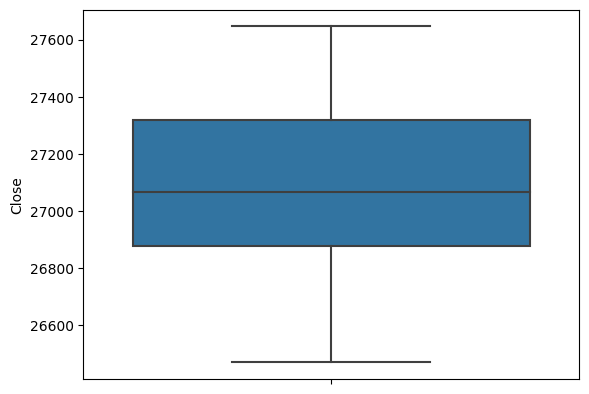

In [18]:
limpieza_datos()
outliers = sns.boxplot(y ="Close", data = df_bitcoin_limpio)

In [19]:
def tomar_decisiones():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision,variacion,df_bitcoin_limpio
    if((precio_actual >= media_bitcoin) & (tendencia == "Baja")):
        algoritmo_decision = "Vender"
    elif((precio_actual < media_bitcoin) & (tendencia == "Alta")):
         algoritmo_decision = "Comprar"
    else:
         algoritmo_decision = "Tomando Decisión"
    return algoritmo_decision
        

In [20]:
tomar_decisiones()

'Tomando Decisión'

In [21]:
#def visualizacion():
#df_bitcoin.insert(len(df_bitcoin.columns),"Promedio", media_bitcoin, allow_duplicates=False)
# plt.figure(figsize=(16,5))
# plt.title("Bitcoin Trading")
# plt.plot(df_bitcoin.index,df_bitcoin["Close"])
# plt.plot(df_bitcoin.index,df_bitcoin["Promedio"])
# plt.annotate(tomar_decisiones(),(df_bitcoin.index[-1],df_bitcoin["Close"][-1]),arrowprops = dict(facecolor ='red', shrink = 0.05),fontsize=12)
#plt.show()

def visualizacion():
    #--------------------------------------------------------
    #--------------------------------------------------------
    if((precio_actual >= media_bitcoin) & (tendencia == "Baja")):
        color ='red'
    elif((precio_actual < media_bitcoin) & (tendencia == "Alta")):
        color ='green'
    else:
        color ='blue'   
     #-------------------------------------------------------
     #-------------------------------------------------------
    df_bitcoin['Promedio'] = media_bitcoin
    sns.set(rc={"figure.figsize":(16, 5)})
    ax = sns.lineplot(data=df_bitcoin, x=df_bitcoin.index, y=df_bitcoin["Close"])
    ax = sns.lineplot(data=df_bitcoin, x=df_bitcoin.index, y=df_bitcoin["Promedio"])
    #ax.text(df_bitcoin.index[-1], df_bitcoin["Close"][-1],tomar_decisiones())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title("Bitcoin Trading")
    ax.set(xlabel=None)
    ax.set(ylabel=None)    
    ax.annotate(tomar_decisiones(),(df_bitcoin.index[-1],df_bitcoin["Close"][-1]),arrowprops = dict(facecolor = color, shrink = 0.05),fontsize=14)
    plt.show()

C:\Users\jlope\AppData\Local\Temp\ipykernel_18440\2235857016.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


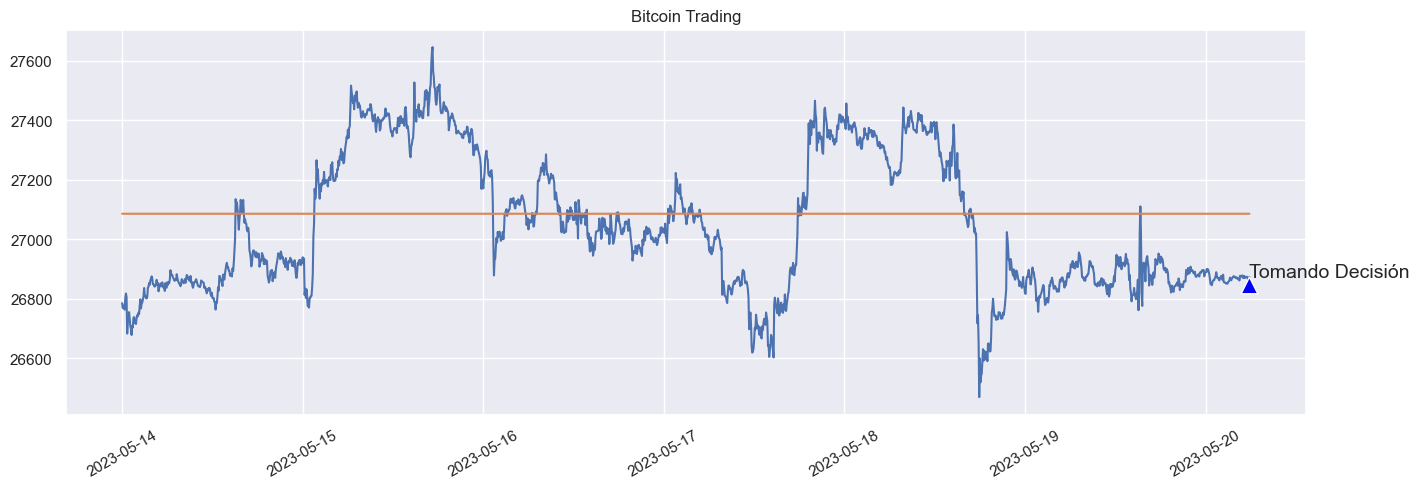

In [22]:
visualizacion()


C:\Users\jlope\AppData\Local\Temp\ipykernel_18440\3727970668.py:12: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_bitcoin_limpio = df_bitcoin_limpio[~((df_bitcoin_limpio< (Q1-1.5*IQR)) & (df_bitcoin_limpio > (Q3+1.5*IQR)))]#|
C:\Users\jlope\AppData\Local\Temp\ipykernel_18440\2235857016.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


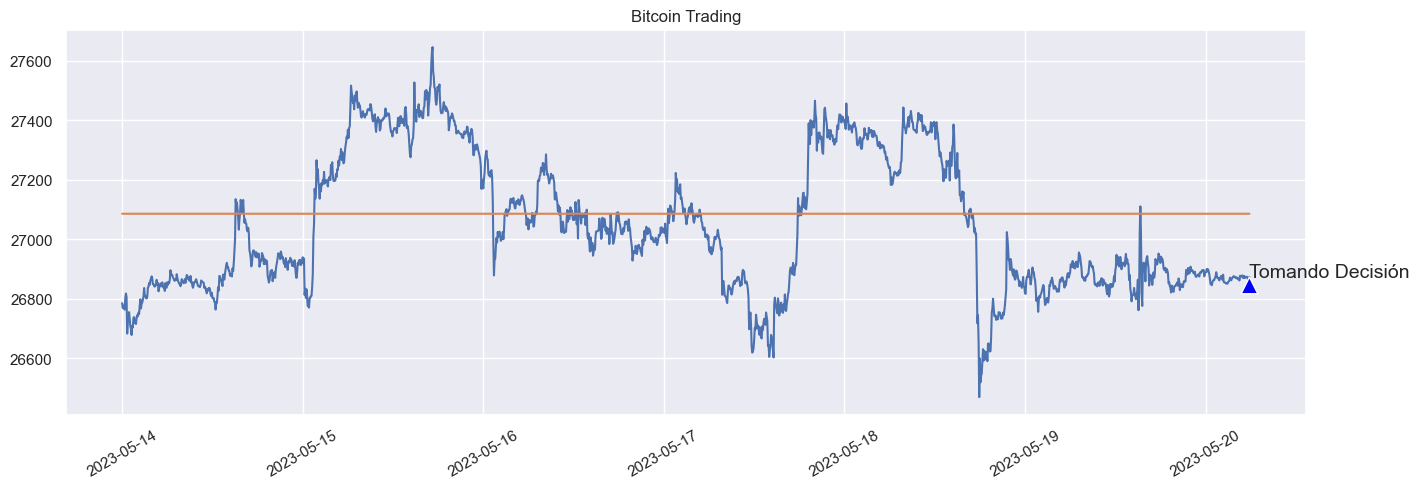

In [23]:
while(True):
   #clear_output()
   #importar_base_bitcoin()
   #extraer_tendencias()
   limpieza_datos()
   tomar_decisiones()
   visualizacion()
   time.sleep(300)